In [3]:
import numpy as np
import matplotlib.pyplot as plt

import lightkurve as lk

from scipy import optimize
from scipy.signal import find_peaks
from astropy.stats import LombScargle

from matplotlib import rcParams
rcParams["figure.dpi"] = 150

from lmfit import Model

import scipy.special
import math

from astropy.io import fits

import random

from astropy.time import Time

import os

from scipy.ndimage import gaussian_filter
from astropy.stats import sigma_clip

In [4]:
from matplotlib import rcParams
rcParams["figure.dpi"] = 150

plt.rc('font', family='serif', size=11)
plt.tight_layout()

<Figure size 900x600 with 0 Axes>

SearchResult containing 4 data products.

target_name                     productFilename                     description  distance
----------- ------------------------------------------------------- ------------ --------
  270577175 tess2018292075959-s0004-0000000270577175-0124-s_lc.fits Light curves      0.0
  270577175 tess2018319095959-s0005-0000000270577175-0125-s_lc.fits Light curves      0.0
  270577175 tess2018349182459-s0006-0000000270577175-0126-s_lc.fits Light curves      0.0
  270577175 tess2019006130736-s0007-0000000270577175-0131-s_lc.fits Light curves      0.0


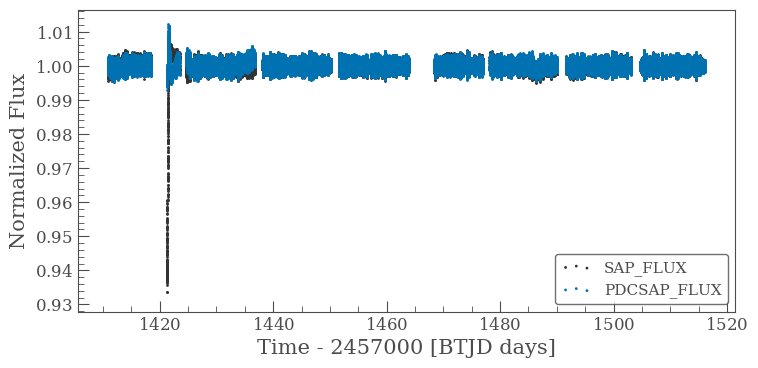

In [5]:
for name in ['beta Pictoris']:
    sr = lk.search_lightcurvefile(name)
    print(sr)

    if len(sr) > 0:

        #Download data
        lcfs = sr.download_all()

        # Use the normalized PDCSAP_FLUX
        lc0 = lcfs[0].SAP_FLUX.normalize()
        lc1 = lcfs[0].PDCSAP_FLUX.normalize()

        # Loop through the rest of the LCFS, appending to the first light curve
        for lcf in lcfs[1:]:
            lc0 = lc0.append(lcf.SAP_FLUX.normalize())
            lc1 = lc1.append(lcf.PDCSAP_FLUX.normalize())

        #Remove bad quality and nans
        q0 = lc0.quality == 0
        lc0 = lc0[q0].remove_nans()
        q1 = lc1.quality == 0
        lc1 = lc1[q1].remove_nans()
        #Plot data
        ax = lc0.scatter(label = 'SAP_FLUX')
        lc1.scatter(ax=ax, label = 'PDCSAP_FLUX')

        
        #Times & Mags
        times = lc1.time + 2457000
        mags = -2.5 * np.log10(lc1.flux)
        mags = mags - np.median(mags)
        
        x = times
        y = mags

In [106]:
jds = []
for i in np.arange(2018, 2023, 1):
    times_utc = ['{0}-01-01T12:00:00'.format(i)]
    t = Time(times_utc, format='isot', scale='utc')
    print(t)
    print(t.jd)
    jds.append(t.jd[0])

['2018-01-01T12:00:00.000']
[2458120.]
['2019-01-01T12:00:00.000']
[2458485.]
['2020-01-01T12:00:00.000']
[2458850.]
['2021-01-01T12:00:00.000']
[2459216.]
['2022-01-01T12:00:00.000']
[2459581.]


In [30]:
def jd_to_datetime(jd, returniso=False):

    tt = Time(jd, format='jd', scale='utc')

    if returniso:
        return tt.iso
    else:
        return tt.datetime 

In [99]:
jd_to_datetime(2458000)

datetime.datetime(2017, 9, 3, 12, 0)

In [107]:
#Expected units:
#t ... Time in days
#a1sini ... in seconds
#Porb ... in days
#star_planet_ratio ... how many times heavier is the star?

def tau(t, star_planet_ratio, a2sini , e, varpi, Porb, tp, nobessel):
    
    Omega = 2 * np.pi / Porb
    
    term1 = -a2sini / star_planet_ratio * 499 / 86400
    term2 = (1-e**2)
    
    sum_cosf = sum(scipy.special.jv(n,n*e)*np.cos(n*Omega*(t-tp)) for n in range(1,nobessel))
    sum_sinf = sum(scipy.special.jvp(n,n*e,n=1)*np.sin(n*Omega*(t-tp)) for n in range(1,nobessel))
    
    
    cosf  = - e + 2*(1-e**2)/e * sum_cosf
    sinf  = 2 * math.sqrt(1 - e**2) * sum_sinf
    
    term3 = (sinf * np.cos(varpi) + cosf * np.sin(varpi))/(1. + e*cosf)
    
    sol = term1*term2*term3
    
    return sol

def vrad(t, star_planet_ratio, a2sini , e, varpi, Porb, tp, nobessel):
    
    Omega = 2 * np.pi / Porb
    
    term1 = - Omega * a2sini / star_planet_ratio *1.736*10**6 #num.value is AU/day into m/s
    term2 = math.sqrt(1-e**2)
    
    sum_cosf = sum(scipy.special.jv(n,n*e)*np.cos(n*Omega*(t-tp)) for n in range(1,nobessel))
    sum_sinf = sum(scipy.special.jvp(n,n*e,n=1)*np.sin(n*Omega*(t-tp)) for n in range(1,nobessel))
    
    
    cosf  = - e + 2*(1-e**2)/e * sum_cosf
    sinf  = 2 * math.sqrt(1 - e**2) * sum_sinf
    
    term3 = (cosf * np.cos(varpi) - sinf * np.sin(varpi)) + e * np.cos(varpi)
    
    sol = term1*term2*term3
    
    return sol

def vrad2(t, star_planet_ratio, a2sini , e, varpi, Porb, tp, nobessel):
    
    Omega = 2 * np.pi / Porb
    
    term1 = - Omega * a2sini / star_planet_ratio  * 1.736*10**6 #num.value is AU/day into m/s
    term2 = math.sqrt(1-e**2)
    
    sum_cosf = sum(scipy.special.jv(n,n*e)*np.cos(n*Omega*(t-tp)) for n in range(1,nobessel))
    sum_sinf = sum(scipy.special.jvp(n,n*e,n=1)*np.sin(n*Omega*(t-tp)) for n in range(1,nobessel))
    
    
    cosf  = - e + 2*(1-e**2)/e * sum_cosf
    sinf  = 2 * math.sqrt(1 - e**2) * sum_sinf
    
    term3 = (cosf * np.cos(varpi) + sinf * np.sin(varpi)) + e * np.cos(varpi)
    
    sol = term1/term2*term3
    
    return sol

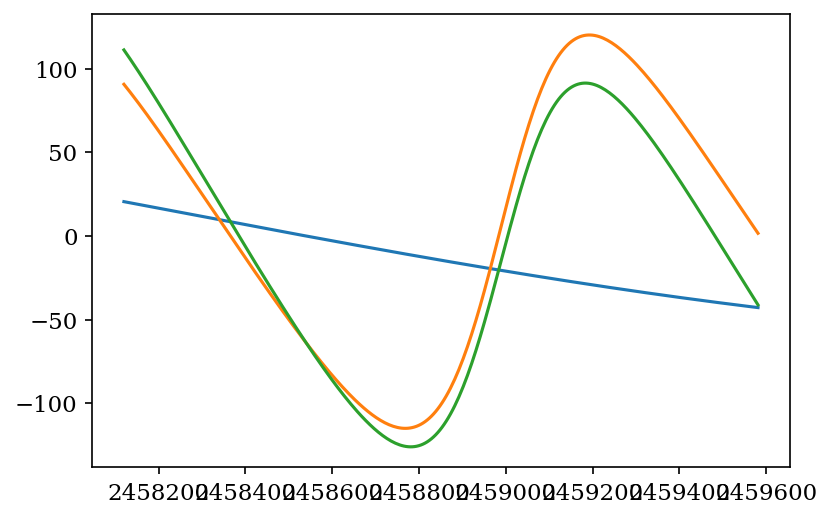

In [108]:
t_18_22 = np.linspace(jds[0], jds[-1], 300)


#_b
star_planet_ratio_b = 1.8 / 9.9 * 1048
a2sini_b = 9.66 * np.sin(np.deg2rad(88.81))
e_b = 0.08
varpi_b = np.deg2rad(205.8)
Porb_b = 22.47*365.25
tp_b = 2455992

#_c
star_planet_ratio_c = 1.8 / 8.93 * 1048
a2sini_c = 2.6947 * np.sin(np.deg2rad(88.81))
e_c = 0.2425
varpi_c = np.deg2rad(-95.2)
Porb_c = 1220
tp_c = 2454116.5

y_tau_b = tau(t_18_22, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_vrad_b = vrad2(t_18_22, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)

y_tau_c = tau(t_18_22, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)
y_vrad_c = vrad2(t_18_22, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)

plt.plot(t_18_22, y_vrad_b)
plt.plot(t_18_22, y_vrad_c)
plt.plot(t_18_22, y_vrad_b + y_vrad_c)

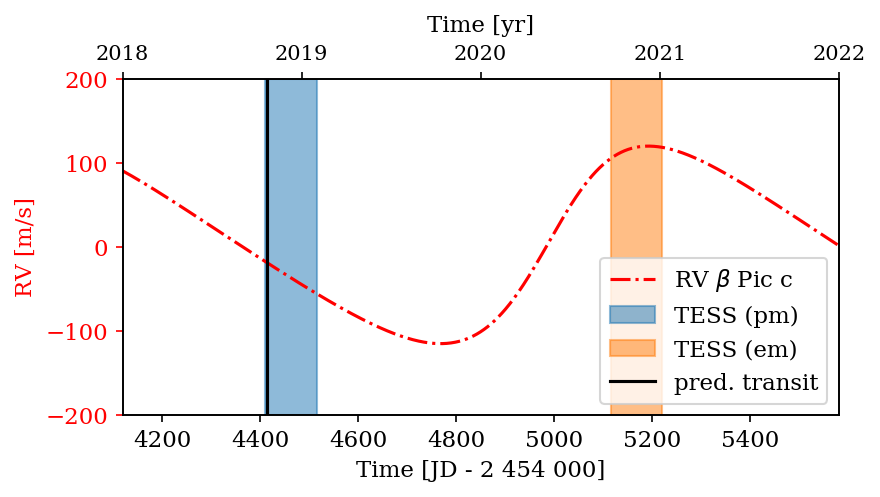

In [204]:
times_sim = np.linspace(jds[0], jds[-1], 1000)

#y_tau_b_sim = tau(times_sim, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)
y_vrad_b_sim = vrad2(times_sim, star_planet_ratio_b, a2sini_b, e_b, varpi_b, Porb_b, tp_b, 100)

y_tau_c_sim = tau(times_sim, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)
y_vrad_c_sim = vrad2(times_sim, star_planet_ratio_c, a2sini_c, e_c, varpi_c, Porb_c, tp_c, 100)

fig, ax1 = plt.subplots(1,1, figsize=(6, 3.5))

time_offset = 2454000

ax1.set_xlim(jds[0] - time_offset, jds[-1] - time_offset)

#lns11 = ax1.plot(times_sim - time_offset, (y_vrad_b_sim + y_vrad_c_sim), 'r', label = r"RV $\beta$ Pic b&c")
#lns12 = ax1.plot(times_sim - time_offset, (y_vrad_b_sim), 'r', ls = '--', label = r"RV $\beta$ Pic b")
lns13 = ax1.plot(times_sim - time_offset, (y_vrad_c_sim), 'r', ls = '-.', label = r"RV $\beta$ Pic c")
ax1.set_xlabel('Time [JD - 2 454 000]')
ax1.set_ylabel('RV [m/s]', color='r')
ax1.tick_params('y', colors='r')
ax1.set_ylim(-200,200)


#ax2 = ax1.twinx()

# lns2 = ax2.plot(times_sim - time_offset, y_vrad_b_sim + y_vrad_c_sim, 'r', label = "RV curve")
# ax2.plot(times_sim - time_offset, y_vrad_b_sim, 'r', label = "RV curve", ls = '--')
# ax2.plot(times_sim - time_offset, y_vrad_c_sim, 'r', label = "RV curve", ls = '-.')
# ax2.set_ylabel('v$_{rad}$ (m/s)', color='r')
# ax2.tick_params('y', colors='r')
# ax2.set_ylim(-200,200)


ax2 = ax1.twiny()
ax2.tick_params(axis='x', rotation=0)

t_2018 = jds[0] - time_offset
t_2019 = jds[1] - time_offset
t_2020 = jds[2] - time_offset
t_2021 = jds[3] - time_offset
t_2022 = jds[4] - time_offset


ax2.set_xticks([t_2018,t_2019,t_2020,t_2021,t_2022])


xmin1, xmax1 = ax1.get_xlim()
ax2.set_xlim(xmin1,xmax1)
ax2.set_xticklabels(['2018', '2019', '2020', '2021', '2022'], fontsize=10)

ax2.set_xlabel('Time [yr]')
ax2.xaxis.set_label_coords(0.5,1.14)

lnsT = ax1.axvline(T_transit(e_c, varpi_c, Porb_c, tp_c ,4) - time_offset, c='k', label='pred. transit') 
lnsT = ax1.axvline(T_transit(e_c, varpi_c, Porb_c, tp_c ,5) - time_offset, c='k', label='pred. transit') 

lns31 = ax1.axvspan(min(times) - time_offset, max(times) - time_offset, alpha=0.5,  label='TESS (pm)', color='C0')
lns32 = ax1.axvspan(min(times)+705 - time_offset, max(times)+705 - time_offset, alpha=0.5,  label='TESS (em)', color='C1')
# lns4 = ax1.axvspan(min(tB15_BJD) - time_offset, max(tB15_BJD) - time_offset, alpha=0.35, color='darkgreen', label='BRITE')
# ax1.axvspan(min(tB16_BJD) - time_offset, max(tB16_BJD) - time_offset, alpha=0.35, color='darkgreen')
# ax1.axvspan(min(tB17_BJD) - time_offset, max(tB17_BJD) - time_offset, alpha=0.35, color='darkgreen')
# lns5 = ax1.axvspan(min(t_bRing) - time_offset, max(t_bRing) - time_offset, alpha=0.5, color='k', label='bRing')
# lns6 = ax1.axvspan(min(t_ASTEP) - time_offset, 2458011.168025- time_offset, alpha=0.35, color='red', label='ASTEP')
# ax1.axvspan(2458206.1510377- time_offset, max(t_ASTEP) - time_offset, alpha=0.35, color='red')


#lns = [lns11[0], lns12[0], lns13[0], lns3]#lns2[0], lns4, lns5, lns6, lns3]
lns = [lns13[0], lns31, lns32, lnsT]
#lns = [lns1[0], lns2[0], lns3]#lns2[0], lns4, lns5, lns6, lns3]
labs = [l.get_label() for l in lns]

#ax1.legend()
ax1.legend(lns, labs, loc=4)

fig.tight_layout()
plt.show()

fig.tight_layout()

fig.savefig("RV_bPicc.png", dpi=400)
fig.savefig("RV_bPicc.pdf")

In [115]:
def T_transit(ecc, arg_peri, peri, time_peri, n):
    E = 2 * np.arctan(np.sqrt((1-ecc)/(1+ecc))*np.tan((np.pi/2 - arg_peri)/2))
    M = E - ecc * np.sin(E)
    t_M = peri * M /(2 * np.pi)
    T = time_peri + t_M + n*peri
    return T

In [137]:
from uncertainties import ufloat

In [133]:
np.sqrt(2.695 **3 /1.8)*365.25

1204.459291799433

In [148]:
from uncertainties import umath

In [149]:
umath.sqrt(ecc)

0.4929503017546495+/-0.0010143010324169743

In [143]:
(1-ecc)/(1+ecc)

0.6090104585679808+/-0.001294457327890572

In [171]:
ecc = ufloat(0.243, 0.001)
arg_peri_deg = ufloat(-95.2, 0.2)*np.pi/180
peri = ufloat(1220, 30)
time_peri = ufloat(2454116.5, 0.5)

In [172]:
from uncertainties.umath import *

In [173]:
E = 2 * atan(umath.sqrt((1-ecc)/(1+ecc))*tan((np.pi/2 - arg_peri_deg)/2))

In [174]:
M = E - ecc * sin(E)

In [175]:
t_M = peri * M /(2 * np.pi)

In [176]:
T = time_peri + t_M + 4*peri

In [177]:
T

2458414.543815627+/-105.69628191891246

In [ ]:
#_b
star_planet_ratio_b = 1.8 / 9.9 * 1048
a2sini_b = 9.66 * np.sin(np.deg2rad(88.81))
e_b = 0.08
varpi_b = np.deg2rad(205.8)
Porb_b = 22.47*365.25
tp_b = 2455992

#_c
star_planet_ratio_c = 1.8 / 8.93 * 1048
a2sini_c = 2.6947 * np.sin(np.deg2rad(88.81))
e_c = 0.2425
varpi_c = np.deg2rad(-95.2)
Porb_c = 1220
tp_c = 2454116.5